In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
import random
import h5py
from PIL import Image

import sys
sys.path.append('/Depth-Anything-V2/metric_depth')

from accelerate import Accelerator
from accelerate.utils import set_seed
from accelerate import notebook_launcher
from accelerate import DistributedDataParallelKwargs

import transformers

import torch
import torchvision
from torchvision.transforms import v2
from torchvision.transforms import Compose
import torch.nn.functional as F
import albumentations as A

from depth_anything_v2.dpt import DepthAnythingV2
from util.loss import SiLogLoss
from dataset.transform import Resize, NormalizeImage, PrepareForNet, Crop

In [16]:
DATAFILE = "/scratchdata/nyuv2"
train_csv = np.genfromtxt(os.path.join(DATAFILE, "data/nyu2_train.csv"), delimiter=",", dtype=str)
test_csv = np.genfromtxt(os.path.join(DATAFILE, "data/nyu2_test.csv"), delimiter=",", dtype=str)


full_train_path = []
full_test_path = []

for i in range(len(train_csv)):
    full_train_path.append([os.path.join(DATAFILE,train_csv[i,0]), os.path.join(DATAFILE,train_csv[i,1])])
    
for i in range(len(test_csv)):
    full_test_path.append([os.path.join(DATAFILE,test_csv[i,0]), os.path.join(DATAFILE,test_csv[i,1])])
    

In [17]:
#NYU Depth V2 40k. Original NYU is 400k
class CSV(torch.utils.data.Dataset):
    def __init__(self, paths, mode, size=(518, 518)):
        
        self.mode = mode #train or val
        self.size = size
        self.paths = paths
        
        net_w, net_h = size
        #author's transforms
        self.transform = Compose([
            Resize(
                width=net_w,
                height=net_h,
                resize_target=True if mode == 'train' else False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method='lower_bound',
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ] + ([Crop(size[0])] if self.mode == 'train' else []))
        
        # only horizontal flip in the paper
        self.augs = A.Compose([
            A.HorizontalFlip(),
            A.ColorJitter(hue = 0.1, contrast=0.1, brightness=0.1, saturation=0.1),
            A.GaussNoise(var_limit=25),
        ])
    
    def __getitem__(self, item):
        path = self.paths[item]
        image, depth = self.torch_loader(path)

        if self.mode == 'train':
            augmented = self.augs(image=image, mask = depth)
            image = augmented["image"] / 255.0
            depth = augmented['mask']
        else:
            image = image / 255.0
          
        sample = self.transform({'image': image, 'depth': depth})

        sample['image'] = torch.from_numpy(sample['image']).to("cuda:0")[None, ...]
        sample['depth'] = torch.from_numpy(sample['depth']).to("cuda:0")[None, ...]
        
        # sometimes there are masks for valid depths in datasets because of noise e.t.c
#         sample['valid_mask'] = ... 
     
        return sample

    def __len__(self):
        return len(self.paths)
    
    def torch_loader(self, path):
        rgb = Image.open(path[0])
        rgb = np.array(rgb)
        depth = Image.open(path[1])
        depth = np.array(depth)
        return rgb, depth

In [18]:
def get_dataloaders(batch_size):
    
    train_dataset = CSV(full_train_path[:len(full_train_path)//1000], mode='train')
    #val_dataset = CSV(full_test_path[:len(full_test_path)//100], mode='val')
    val_dataset = CSV(full_test_path[:2], mode='val')
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                  batch_size = batch_size,
                                                  shuffle=True,
                                                  num_workers=4,
                                                  drop_last=True
                                                  )

    val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size = 1, #for dynamic resolution evaluations without padding
                                               shuffle=False,
                                               num_workers=4,
                                               drop_last=True
                                                )
    
    return train_dataloader, val_dataloader


In [19]:
def eval_depth(pred, target):
    print(pred.max(), pred.min())
    print(target.max(), target.min())
    assert pred.shape == target.shape

    thresh = torch.max((target / pred), (pred / target))

    d1 = torch.sum(thresh < 1.25).float() / len(thresh)

    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    abs_rel = torch.mean(torch.abs(diff) / target)

    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    mae = torch.mean(torch.abs(diff))

    silog = torch.sqrt(torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2))

    return {'d1': d1.detach(), 'abs_rel': abs_rel.detach(),'rmse': rmse.detach(), 'mae': mae.detach(), 'silog':silog.detach()}


In [20]:
model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
model_encoder = 'vitl'
model_weights_path =  f'/scratchdata/depth_anything_v2_metric_hypersim_vitl.pth' 

max_depth = 3000#mm
batch_size = 11
lr = 5e-6
weight_decay = 0.01
num_epochs = 10
warmup_epochs = 0.5
scheduler_rate = 1
load_state = False

state_path = os.path.join(DATAFILE, "ws")
save_model_path = os.path.join(DATAFILE, "models")
seed = 42
mixed_precision = 'fp16'

In [21]:
def train_fn():

    set_seed(seed)
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True) 
    accelerator = Accelerator(mixed_precision=mixed_precision, 
                              kwargs_handlers=[ddp_kwargs],
                             )
    
    # in the paper they initialize decoder randomly and use only encoder pretrained weights. Then full fine-tune
    # ViT-S encoder here
    model = DepthAnythingV2(**{**model_configs[model_encoder], 'max_depth': max_depth})
    model.load_state_dict({k: v for k, v in torch.load(model_weights_path).items() if 'pretrained' in k}, strict=False)
    
    optim = torch.optim.AdamW([{'params': [param for name, param in model.named_parameters() if 'pretrained' in name], 'lr': lr},
                       {'params': [param for name, param in model.named_parameters() if 'pretrained' not in name], 'lr': lr*10}],
                      lr=lr, weight_decay=weight_decay)
    
    criterion = SiLogLoss() # author's loss
    
    train_dataloader, val_dataloader = get_dataloaders(batch_size)
    
    scheduler = transformers.get_cosine_schedule_with_warmup(optim, len(train_dataloader)*warmup_epochs, num_epochs*scheduler_rate*len(train_dataloader))
    
    model, optim, train_dataloader, val_dataloader, scheduler = accelerator.prepare(model, optim, train_dataloader, val_dataloader, scheduler)
    
    if load_state:
        accelerator.wait_for_everyone()
        accelerator.load_state(state_path)
        
    best_val_absrel = 1000
    
    
    for epoch in range(1, num_epochs):
        
        model.train()
        train_loss = 0
        for sample in tqdm(train_dataloader.dataset, disable = not accelerator.is_local_main_process):
            optim.zero_grad()

            img, depth = sample['image'], sample['depth']

            pred = model(img) 
                                                     # mask
            loss = criterion(pred, depth, (depth <= max_depth) & (depth >= 0.001))
            
            accelerator.backward(loss)
            optim.step()
            scheduler.step()
            
            train_loss += loss.detach()
            
            
        train_loss /= len(train_dataloader)
        train_loss = accelerator.reduce(train_loss, reduction='mean').item()
        
        
        model.eval()
        results = {'d1': 0, 'abs_rel': 0,'rmse': 0, 'mae': 0, 'silog': 0}
        for sample in tqdm(val_dataloader.dataset, disable = not accelerator.is_local_main_process):

            img, depth = sample['image'], sample['depth'][0]
            
            with torch.no_grad():
                pred = model(img)
                # evaluate on the original resolution 
                pred = F.interpolate(pred[:, None], depth.shape[-2:], mode='bilinear', align_corners=True)[0, 0]
            
            valid_mask = (depth <= max_depth) & (depth >= 0.001)
            cur_results = eval_depth(pred[valid_mask], depth[valid_mask])
            
            for k in results.keys():
                results[k] += cur_results[k]
            

        for k in results.keys():
            results[k] = results[k] / len(val_dataloader)
            results[k] = round(accelerator.reduce(results[k], reduction='mean').item(),3)
        
        accelerator.wait_for_everyone()
        accelerator.save_state(state_path, safe_serialization=False)
        
        if results['abs_rel'] < best_val_absrel:
            best_val_absrel = results['abs_rel']
            unwrapped_model = accelerator.unwrap_model(model)
            if accelerator.is_local_main_process:
                torch.save(unwrapped_model.state_dict(), os.path.join(save_model_path, f"best_{model_encoder}.pth"))
        
        accelerator.print(f"epoch_{epoch},  train_loss = {train_loss:.5f}, val_metrics = {results}")

In [22]:
model = DepthAnythingV2(**{**model_configs[model_encoder], 'max_depth': max_depth})
model.load_state_dict({k: v for k, v in torch.load(model_weights_path).items() if 'pretrained' in k}, strict=False)
model = model.to("cuda")

/tmp/ipykernel_2086/2781952825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict({k: v for k, v in torch.load(model_weights_path).items() if 'pretrai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img:  tensor(3.4280, device='cuda:0') tensor(-2.7082, device='cuda:0')
Real Depth:  tensor(3615., device='cuda:0') tensor(1798., device='cuda:0')
Pred Depth:  tensor(1552.8979, device='cuda:0') tensor(1474.0414, device='cuda:0')


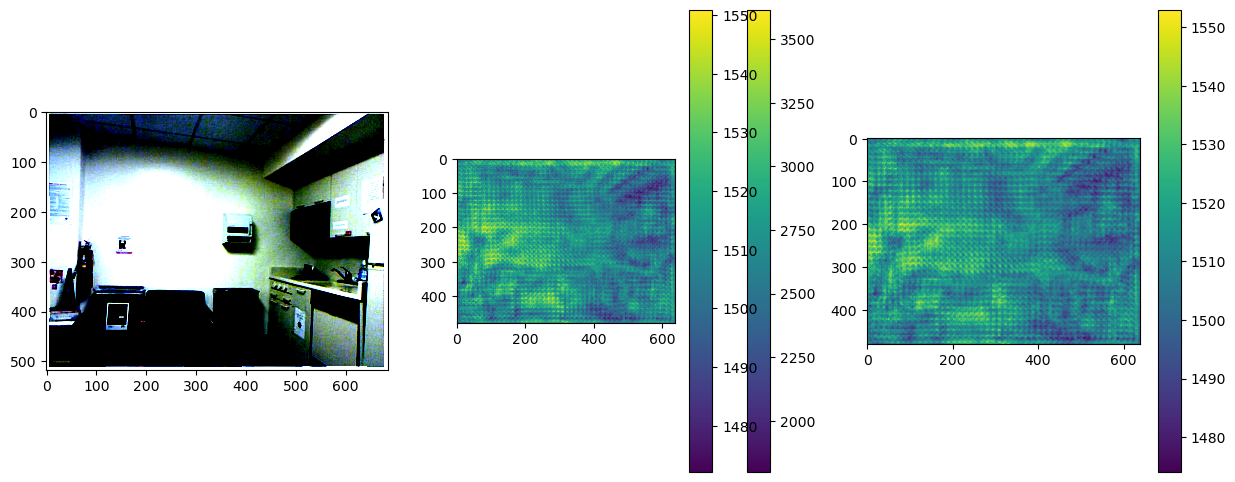

In [23]:
#Set fig size
plt.rcParams['figure.figsize'] = [15, 6]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to("cuda:0")
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to("cuda:0")

train_dataloader, val_dataloader = get_dataloaders(batch_size)
for i in range(len(val_dataloader)):
    img, depth = val_dataloader.dataset[i]['image'], val_dataloader.dataset[i]['depth'][0]
    #img = img*std + mean
    
    print("Img: ", img.max(), img.min())
    print("Real Depth: ", depth.max(), depth.min())
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(img[0].permute(1, 2, 0).cpu().numpy())
    tmp = ax[1].imshow(depth.cpu().numpy())
    fig.colorbar(tmp, ax=ax[1])
    
    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred[:, None], depth.shape[-2:], mode='bilinear', align_corners=True)[0, 0]
    
    print("Pred Depth: ", pred.max(), pred.min())
    
    tmp = ax[2].imshow(pred.cpu().numpy())
    fig.colorbar(tmp, ax=ax[2])
    
    ori = Image.open(full_test_path[i][0])
    ori = np.array(ori)

    pred = model.infer_image(ori)
    tmp = ax[1].imshow(pred)
    fig.colorbar(tmp, ax=ax[1])
    
    break

In [24]:
#You can run this code with 1 gpu. Just set num_processes=1
#notebook_launcher(train_fn, num_processes=1)
